# Practical work on filter banks

Bruno Pons

In [138]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
%matplotlib ipympl
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

In [139]:
from scipy import signal
from scipy.linalg import hankel

# Functions

In [140]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

# Reading and playing .wav file

In [141]:
data_path = os.getcwd()
filename = 'homme3.wav'
sound = os.path.join(data_path, filename) 

In [142]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [143]:
play = False
if play :
    play_sound(sound) 

In [144]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [145]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

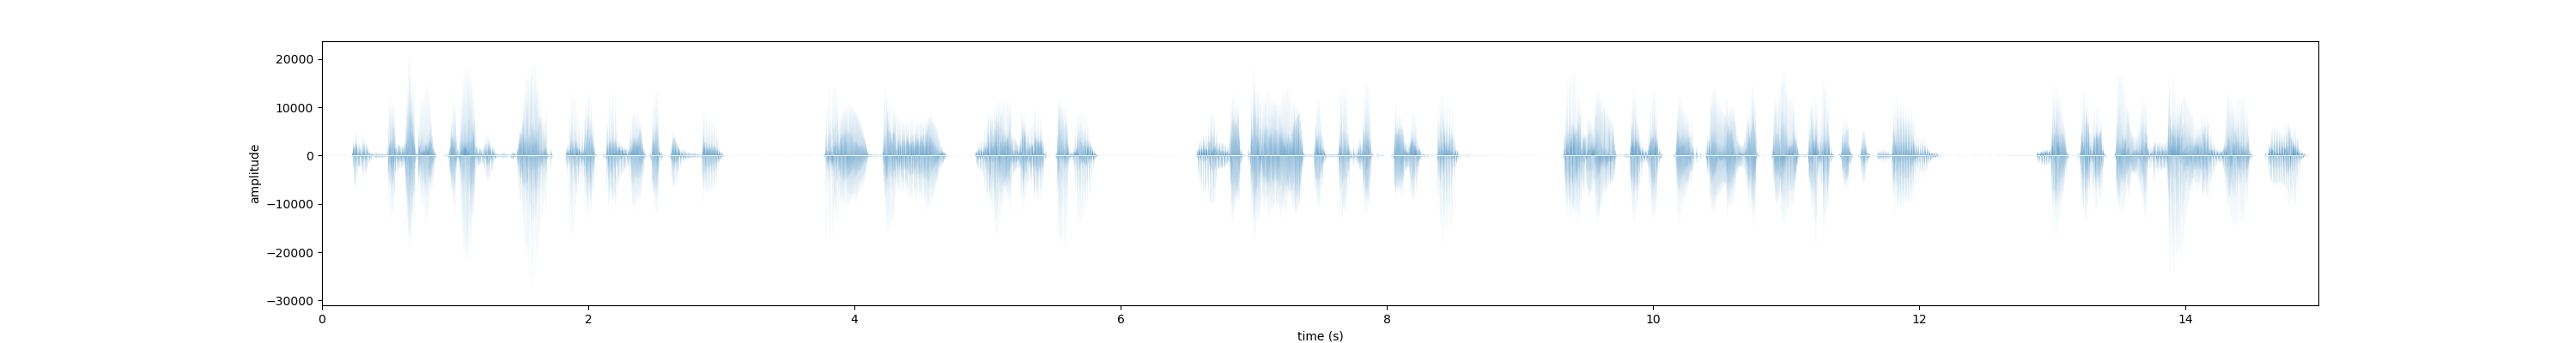

In [146]:
plot_sound(x, times)

# Two-channel filter bank

## 1.1 CQF filter bank

## 1.2 Synthesis of a half-band filter

## 1.

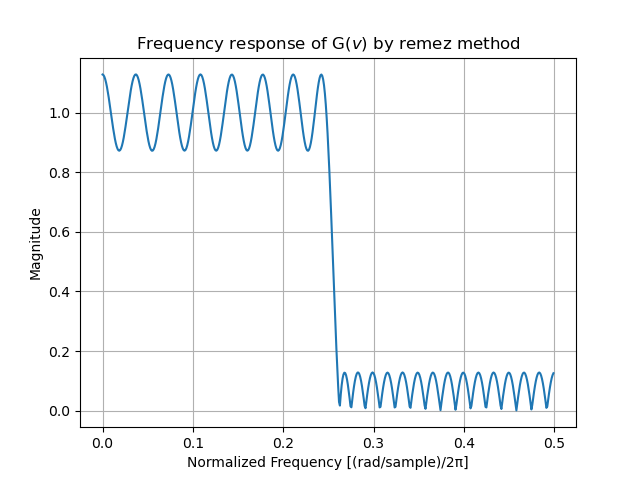

In [147]:
N = 61    # length of filter
nu_c = 1/4  # cutoff frequency
nu_a = 0.26 # beggining frequency of the stopband
L = 1       # band gain

g = signal.remez(N, [0, nu_c, nu_a, .5], [L,0])  # filter synthesis
w, G = signal.freqz(g) # frequency response
w_norm = w/(2*np.pi)  # normalized frequency


fig, ax = plt.subplots()
xplot=w_norm
yplot=np.abs(G)
ax.plot(xplot,yplot)
plt.title("Frequency response of G($v$) by remez method")
plt.ylabel("Magnitude")
plt.xlabel("Normalized Frequency [(rad/sample)/2π]")
ax.grid()

plt.show()

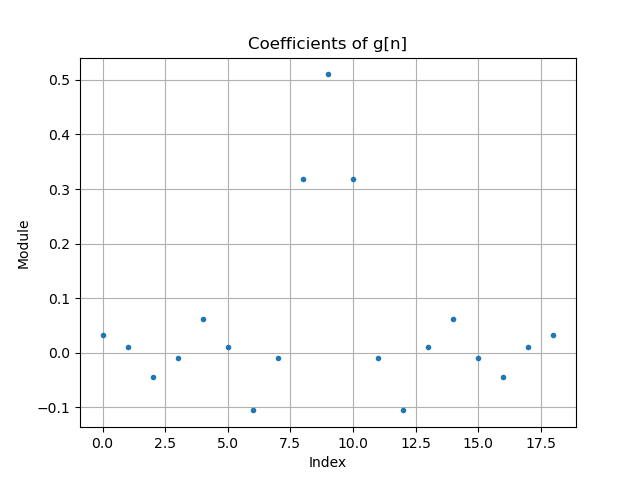

In [148]:
# To visualize the coefficients of g[n] created by remez method
fig, ax = plt.subplots()
xplot=np.arange(len(g[int (N/2) -9:int (N/2) +10]))
yplot=g[int (N/2) -9:int (N/2) +10]
ax.plot(xplot,yplot,'.')
plt.title("Coefficients of g[n]")
plt.ylabel("Module")
plt.xlabel("Index")
plt.grid()
plt.show()

The half-band condition is not regorously hold, we can see that when viewing the coefficients of g(n) it is not met the condition where one out of two must be regorously zero.

## 2.

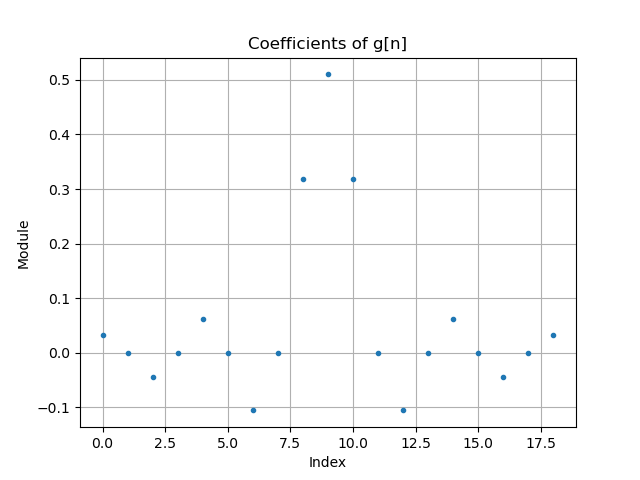

In [149]:
# Modification of the obtained filter by remez method
gtilde = g
c = g[ int(len(g)/2) ]
gtilde[::2] = 0
gtilde[int(len(g)/2) ] = c

#Plot coefficients
fig, ax = plt.subplots()
yplot=gtilde[int (N/2) -9:int (N/2) +10]
ax.plot(yplot,'.')
plt.title("Coefficients of g[n]")
plt.ylabel("Module")
plt.xlabel("Index")
ax.grid()

plt.show()

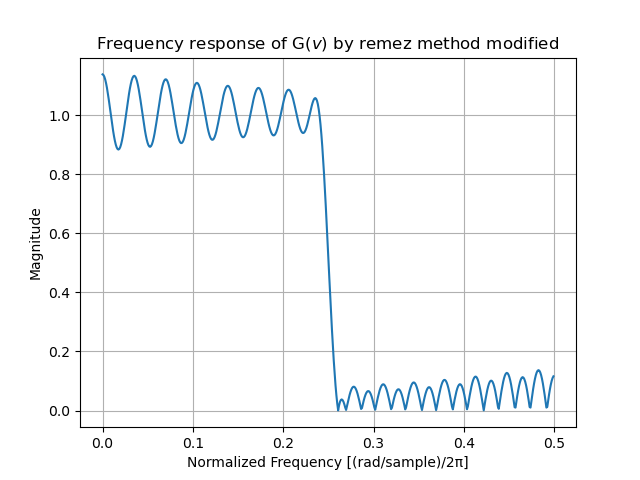

In [150]:
#Ploting frecuency response
wtilde, Gtilde = signal.freqz(gtilde) # frequency response
w_norm_tilde = wtilde/(2*np.pi)  # normalized frequency


fig, ax = plt.subplots()
xplot=w_norm_tilde
yplot=np.abs(Gtilde)
ax.plot(xplot,yplot)
plt.title("Frequency response of G($v$) by remez method modified")
plt.ylabel("Magnitude")
plt.xlabel("Normalized Frequency [(rad/sample)/2π]")
ax.grid()

No, Chebyshev's alternance property isn't regorously hold because we have changed the coefficients (those coefficients obtained by remez construction satisfied Chebyshev's alternance property). Also if we see the plot, we can observe indesired perturbations in the pass-band and stop-band, that we hadn't before, that fenomen is explained by Chebyshev's alternance property not being hold.

## 3.

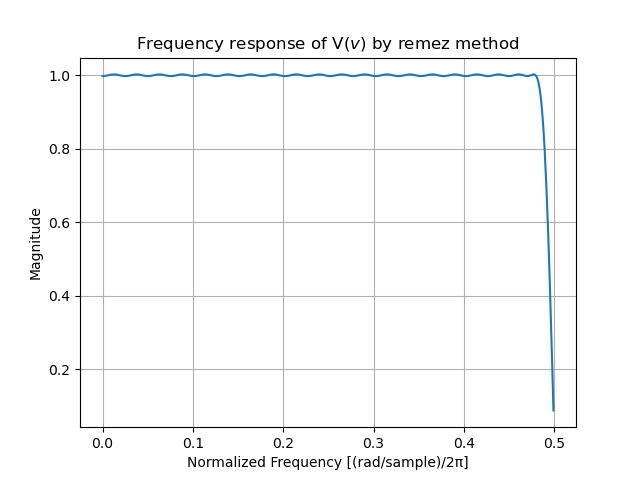

In [151]:
N = 80    # length of filter even
nu_c = 0.48  # cutoff frequency
nu_a = 0.5 # beggining frequency of the stopband
L = 1       # band gain

v = signal.remez(N, [0, nu_c, nu_a, .5], [L,0])  # filter synthesis
w_v, V = signal.freqz(v) # frequency response
w_norm_v = w_v/(2*np.pi)  # normalized frequency



fig, ax = plt.subplots()
xplot=w_norm_v
yplot=np.abs(V)
ax.plot(xplot,yplot)
plt.title("Frequency response of V($v$) by remez method")
plt.ylabel("Magnitude")
plt.xlabel("Normalized Frequency [(rad/sample)/2π]")
ax.grid()


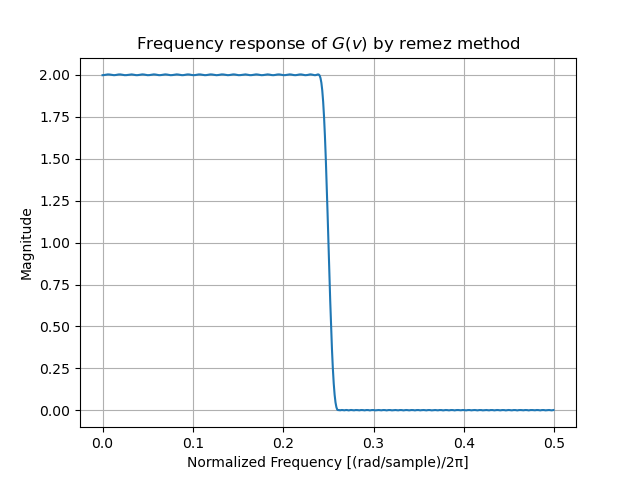

In [152]:
#creating g(n)
c=1
g_n = np.zeros(2*len(v)-1)
g_n[::2] = c*v
g_n[N-1] = g_n[N-1] + c

w_g, G_N = signal.freqz(g_n) # frequency reponse
w_g = w_g/(2*np.pi)  # normalized frequency

fig, ax = plt.subplots()
xplot=w_g
yplot=np.abs(G_N)
ax.plot(xplot,yplot)
plt.title("Frequency response of $G(v)$ by remez method")
plt.ylabel("Magnitude")
plt.xlabel("Normalized Frequency [(rad/sample)/2π]")
ax.grid()

## 1.3 Raising and factorization of the half-band filter

## 4.

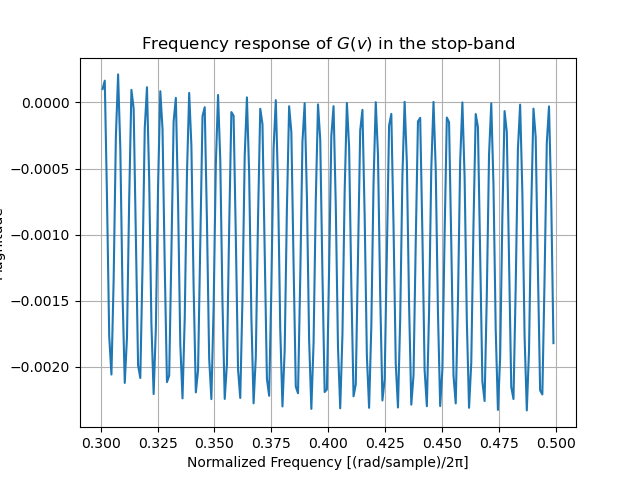

In [153]:
begining_stopband = np.where(w_g > 0.30)[0][0]


fig, ax = plt.subplots()
xplot=w_g[begining_stopband::]
yplot=np.real(G_N[begining_stopband::])
ax.plot(xplot,yplot)
plt.title("Frequency response of $G(v)$ in the stop-band")
plt.ylabel("Magnitude")
plt.xlabel("Normalized Frequency [(rad/sample)/2π]")
ax.grid()

As we plot the real value of the function $G(v)$ in the stop-band we can observe that it takes negative values. This was expected according to the theory viewed in class, furthermore it is not possible to factorise $G(v)$ in the form $G(v)=\tilde H_0(e^{2i\pi v})H_0(e^{2i\pi v})$, so in order to do this we will implement the following steps.

## 5.

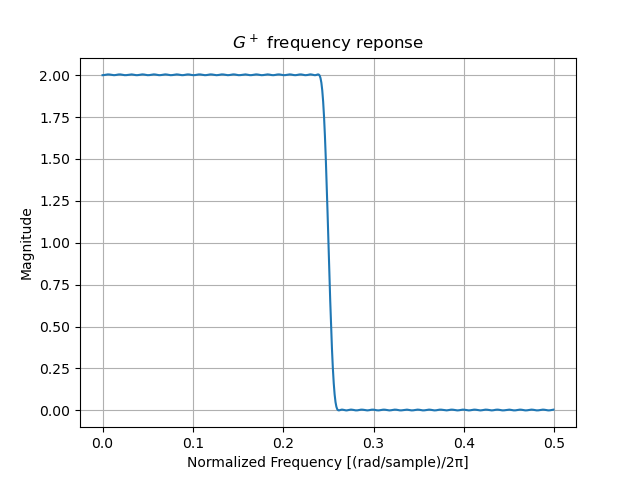

In [154]:
# Calculate the delta of the Chebyshev’s alternance property of the filter GR
delta = max(np.abs(np.real(G_N)[begining_stopband::]))


# Calculating G+

g_plus = np.zeros(len(g_n))
g_plus = g_n
g_plus[N-1] = g_plus[N-1] + delta

w_plus, G_PLUS = signal.freqz(g_plus) # frequency reponsebb
w_plus = w_plus/(2*np.pi)  # normalized frequency

fig, ax = plt.subplots()
xplot=w_plus
yplot=np.abs(G_PLUS)
ax.plot(xplot,yplot)
plt.title('$G^+$ frequency reponse')
plt.ylabel("Magnitude")
plt.xlabel("Normalized Frequency [(rad/sample)/2π]")
ax.grid()


# 1.4 Implementation of the CQF filter bank

## 7.

In [155]:
gN= g_plus[0:N]
h0 = np.zeros(N)
h0[0] = 1
first_col=np.zeros(N)
first_col[N-1]=h0[0]
matrix = hankel(first_col,r=h0)


epsilon = 5e-4
error= np.linalg.norm(gN - matrix@h0)

while error>epsilon:
    
    matrix = np.linalg.inv(matrix)
    h0 = matrix@gN

    #normalize
    norm = np.linalg.norm(h0)
    h0 = h0/norm * np.sqrt(abs(gN[N-1]))

    #redefine matrix
    first_col[N-1]=h0[0]
    matrix = hankel(first_col,r=h0)
    
    #calculate error
    error= np.linalg.norm(gN - matrix@h0)


In [156]:
# Calculating filters

sign = np.zeros(N)
for i in range(N):
    sign[i] = (-1)**i



f0 = np.flip(h0)

h1 = -1*sign*np.flip(h0)

f1 = sign*h0

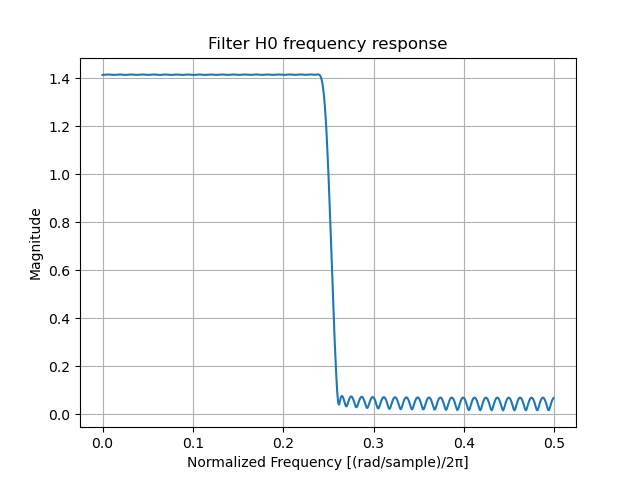

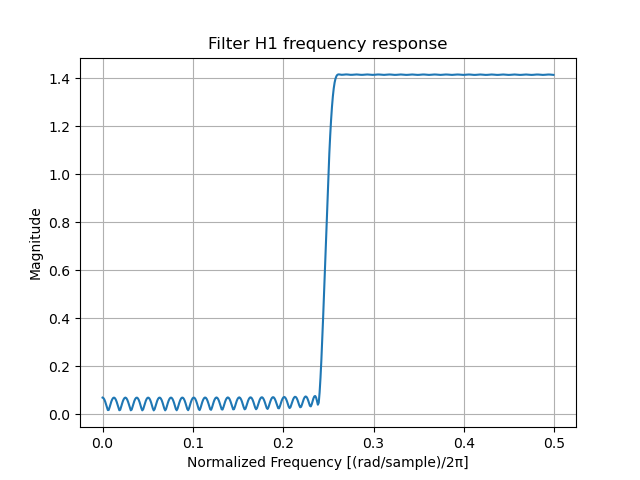

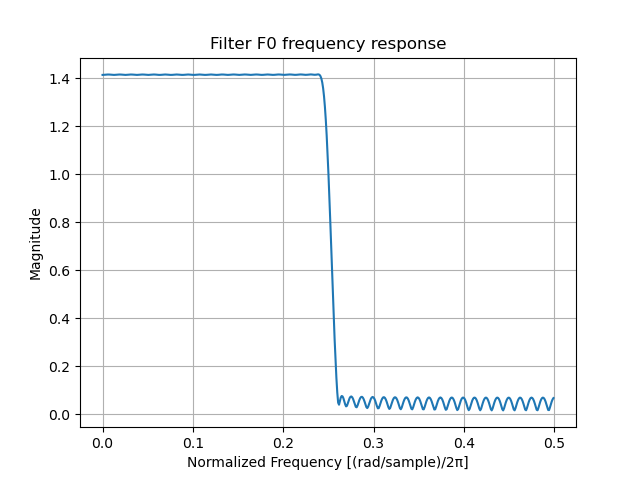

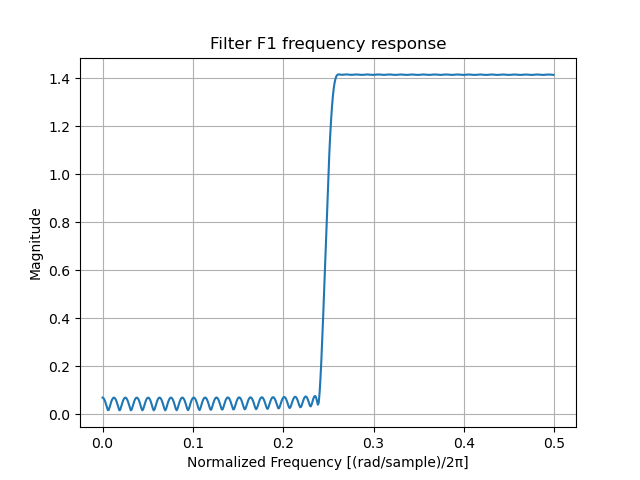

In [157]:
w_H0, H0 = signal.freqz(h0) # frequency response
w_H0 = w_H0/(2*np.pi)  # normalized frequency

fig, ax = plt.subplots()
xplot= w_H0
yplot= np.abs(H0)
ax.plot(xplot,yplot)
plt.title('Filter H0 frequency response')
plt.ylabel("Magnitude")
plt.xlabel("Normalized Frequency [(rad/sample)/2π]")
ax.grid()


w_H1, H1 = signal.freqz(h1) # frequency response
w_H1 = w_H1/(2*np.pi)  # normalized frequency

fig, ax = plt.subplots()
xplot= w_H1
yplot= np.abs(H1)
ax.plot(xplot,yplot)
plt.title('Filter H1 frequency response')
plt.ylabel("Magnitude")
plt.xlabel("Normalized Frequency [(rad/sample)/2π]")
ax.grid()


w_F0, F0 = signal.freqz(f0) # frequency response
w_F0 = w_F0/(2*np.pi)  # normalized frequency

fig, ax = plt.subplots()
xplot= w_F0
yplot= np.abs(F0)
ax.plot(xplot,yplot)
plt.title('Filter F0 frequency response')
plt.ylabel("Magnitude")
plt.xlabel("Normalized Frequency [(rad/sample)/2π]")
ax.grid()


w_F1, F1 = signal.freqz(f1) # frequency response
w_F1 = w_F1/(2*np.pi)  # normalized frequency

fig, ax = plt.subplots()
xplot= w_F1
yplot= np.abs(F1)
ax.plot(xplot,yplot)
plt.title('Filter F1 frequency response')
plt.ylabel("Magnitude")
plt.xlabel("Normalized Frequency [(rad/sample)/2π]")
ax.grid()

## 8. Test the perfect reconstruction on the provided signal

In [158]:
#Filtering
s0_tilde = signal.lfilter(h0,1,x)
s1_tilde = signal.lfilter(h1,1,x)
#Downsampling
s0 = s0_tilde[::2]
s1 = s1_tilde[::2]

#Upsampling
s0_hat = np.zeros(2*len(s0))
s0_hat[::2] = s0
s1_hat = np.zeros(2*len(s1))
s1_hat[::2] = s1
#Filtering
x0_hat = signal.lfilter(f0,1,s0_hat)
x1_hat = signal.lfilter(f1,1,s1_hat)

#Sum
x_hat = x0_hat + x1_hat

In [159]:
x_norm = x_hat/np.max(x_hat) * np.max(x)
diference = np.mean(x_norm - x)
print(diference)

0.001473173160169376


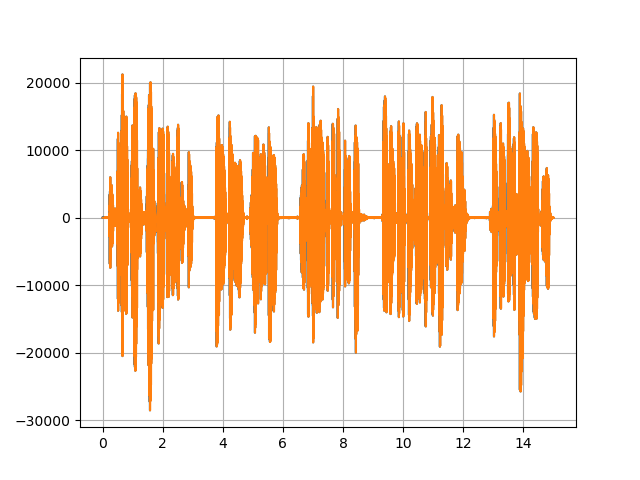

In [160]:
fig, ax = plt.subplots()
y1=x
y2=x_norm
ax.plot(times,y1)
ax.plot(times,y2)
ax.grid()

In [161]:
write('reconstruction_CQF.wav', Fs, np.array(x_hat, dtype=np.int16)) # write a new wave file


data_path = os.getcwd()
filename = 'reconstruction_CQF.wav'
sound = os.path.join(data_path, filename) 

wavefile = load_sound(sound)

play = False
if play :
    play_sound(sound)

The reconstruction we obtained is perfect, we can also listen to it and notice that there are no differences with the original audio.

# 2 Transmultiplexer

## 1.

In [162]:
# Fetch homme3.wav audiofile

data_path = os.getcwd()
filename = 'homme3.wav'
sound = os.path.join(data_path, filename) 

wavefile = load_sound(sound)
print(wavefile.getparams())

Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
man = np.array(data)

timestep = 1/float(Fs)
times_man = np.arange(len(man))*timestep


_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [163]:
# Fetch femme3.wav audiofile

data_path = os.getcwd()
filename = 'femme3.wav'
sound = os.path.join(data_path, filename) 

wavefile = load_sound(sound)
print(wavefile.getparams())

Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
woman = np.array(data)

timestep = 1/float(Fs)
times_woman = np.arange(len(woman))*timestep

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [164]:
#Upsampling
man_tilde = np.zeros(2*len(man))
man_tilde[::2] = man
woman_tilde = np.zeros(2*len(woman))
woman_tilde[::2] = woman

#Filtering
man_hat = signal.lfilter(f0,1,man_tilde)
woman_hat = signal.lfilter(f1,1,woman_tilde)

#Sum
sum_man_woman = man_hat + woman_hat

#Filter C(z)
c1 = sum_man_woman
c1[1:] = sum_man_woman[:(len(sum_man_woman)-1)] 
c1[0] = 0



In [165]:
#Listen to the mix of the two speech sounds

write('sum_man_woman.wav', Fs, np.array(sum_man_woman, dtype=np.int16)) # write a new wave file


data_path = os.getcwd()
filename = 'sum_man_woman.wav'
sound = os.path.join(data_path, filename) 

wavefile = load_sound(sound)

play = False
if play :
    play_sound(sound)

In [166]:
#Filtering
y_man_tilde = signal.lfilter(h0,1,c1)
y_woman_tilde = signal.lfilter(h1,1,c1)

#Downsampling
y_man = y_man_tilde[::2]
y_woman = y_woman_tilde[::2]


In [167]:
# Listen to retrived signal from homme3.wav


write('out_man.wav', Fs, np.array(y_man, dtype=np.int16)) # write a new wave file


data_path = os.getcwd()
filename = 'out_man.wav'
sound = os.path.join(data_path, filename) 

wavefile = load_sound(sound)
print(wavefile.getparams())

play = False
if play :
    play_sound(sound)

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [168]:
# Listen to retrived signal from femme3.wav

write('out_woman.wav', Fs, np.array(y_woman, dtype=np.int16)) # write a new wave file


data_path = os.getcwd()
filename = 'out_woman.wav'
sound = os.path.join(data_path, filename) 

wavefile = load_sound(sound)

play = False
if play :
    play_sound(sound)

Effectively there is perfect reconstruction and each signal is retrived from the right output.

## 2.

We assume that the transfer function of a transmission channel is $C(z)=1-\alpha z^{-1}$.
In order to keep the perfect reconstruction condition property at the output of the transmultiplexer, we just introduce a causal filter $D(z)$ at the output of $C(z)$ such that $C(z)D(z) = \beta z^{-n_0}$, where $n_0$ is an odd number.

Then, we obtain $D(z) = \frac{\beta z^{-n_0}}{1-\alpha z^{-1}}$ that in time is $d(n) = \beta \alpha ^{n-n_0} u(n-n_0)$, where $u(n)$ is the step function.

a)

In [169]:
#Load of homme3.wav
data_path = os.getcwd()
filename = 'homme3.wav'
homme_sound = os.path.join(data_path, filename) 
wavefile = load_sound(homme_sound)

print(wavefile.getparams())

Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
homme = np.array(data)


play = False
if play :
    play_sound(homme_sound) 

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [170]:
#Load of femme3.wav
data_path = os.getcwd()
filename = 'femme3.wav'
femme_sound = os.path.join(data_path, filename) 
wavefile = load_sound(femme_sound)

print(wavefile.getparams())

Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
femme = np.array(data)


play = False
if play :
    play_sound(femme_sound) 

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [171]:
#Define D
alpha = 0.9
n0 = 1
beta = 1

d = np.zeros(N)
for n in range(n0,N):
    d[n] = beta*(alpha**(n-n0))

#Define C
c = np.zeros(N)
c[0] = 1
c[1] = -alpha

In [172]:
#Upsampling and filtering
homme_t = np.zeros(2*len(homme))         
homme_t[::2] = homme
homme_h = signal.lfilter(f0,1, homme_t)

femme_t = np.zeros(2*len(femme))         
femme_t[::2] = femme
femme_h = signal.lfilter(f1,1, femme_t)

sumHF = homme_h+femme_h

In [173]:
#Channel
sumfC = signal.lfilter(c,1, sumHF)
sumfCD = signal.lfilter(d,1, sumfC)

#Downsampling
h_t = signal.lfilter(h0,1, sumfCD)
out_h = h_t[::2]                    

f_t = signal.lfilter(h1,1, sumfCD)
out_f = f_t[::2] 

In [174]:
homme_norm = out_h/np.max(out_h) * np.max(homme)
diference = np.mean(homme_norm - homme)
print(diference)

0.00045217183339862915


In [175]:
#Listen homme
write('rec_homme.wav', Fs, np.array(out_h, dtype=np.int16)) # to write a new wave file
filename = 'rec_homme.wav'
rec_h = os.path.join(data_path, filename) 
wavefile = load_sound(rec_h)

play = False
if play :
    play_sound(rec_h) 

In [176]:
#Listen femme
write('rec_femme.wav', Fs, np.array(out_f, dtype=np.int16)) # to write a new wave file
filename = 'rec_femme.wav'
rec_f = os.path.join(data_path, filename) 
wavefile = load_sound(rec_f)

play = False
if play :
    play_sound(rec_f) 

The implementation of the filter $D(z)$ worked fine and we were able to obtain in the outputs the perfect reconstructions of the input signals.

b)

If $\alpha$ = 1.2, then the causal implementation of the filter $D(z) = \frac{dz^{−n0}}{1−αz−1}$ is unstable because of the pole out of the unit circle.

In order to utilize the stable implementation (that is IIR and anti-causal) we have to approximate it by a causal FIR filter. For achiving this we are going to truncate the IIR filtre and translating it for making it causal.

From this expresion $D(z) = \frac{\beta z^{-n_0}}{1-\alpha z^{-1}}$ we can obtain the expresion in time that we desire $d[n]=-\beta \alpha^{n-n0} u[-n -1 -n0]$.

In [177]:
#Load of homme3.wav
data_path = os.getcwd()
filename = 'homme3.wav'
homme_b = os.path.join(data_path, filename) 
wavefile = load_sound(homme_b)

print(wavefile.getparams())

Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
hommeb = np.array(data)


play = False
if play :
    play_sound(homme_b) 

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [178]:
#Load of femme3.wav
data_path = os.getcwd()
filename = 'femme3.wav'
femme_b = os.path.join(data_path, filename) 
wavefile = load_sound(femme_b)

print(wavefile.getparams())

Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
femmeb = np.array(data)


play = False
if play :
    play_sound(femme_b) 

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


In [179]:

#Define D1
alpha1 = 1.2
n01 = 1
beta1 = 1

d1 = np.zeros(N)
for n in range(1+n0,N):
    d1[n] = -beta1*(alpha1**(-n-n01))

d1=np.flip(d1)

#Define C
c1 = np.zeros(N)
c1[0] = 1
c1[1] = -alpha


In [180]:
#Upsampling and filtering
homme_tb = np.zeros(2*len(hommeb))         
homme_tb[::2] = hommeb
homme_hb = signal.lfilter(f0,1, homme_tb)

femme_tb = np.zeros(2*len(femmeb))         
femme_tb[::2] = femmeb
femme_hb = signal.lfilter(f1,1, femme_tb)

sumHFb = homme_hb+femme_hb

In [181]:
#Channel
sumfCb = signal.lfilter(c1,1, sumHFb)
sumfCDb = signal.lfilter(d1,1, sumfCb)

#Downsampling
h_tb = signal.lfilter(h0,1, sumfCDb)
out_hb = h_tb[::2]                    

f_tb = signal.lfilter(h1,1, sumfCDb)
out_fb = f_tb[::2]  

In [182]:
#Listen homme
write('rec_hommeb.wav', Fs, np.array(out_hb, dtype=np.int16)) # to write a new wave file
filename = 'rec_hommeb.wav'
rec_hb = os.path.join(data_path, filename) 
wavefile = load_sound(rec_hb)

play = False
if play :
    play_sound(rec_hb) 

In [183]:
#Listen femme
write('rec_femmeb.wav', Fs, np.array(out_fb, dtype=np.int16)) # to write a new wave file
filename = 'rec_femmeb.wav'
rec_fb = os.path.join(data_path, filename) 
wavefile = load_sound(rec_fb)

play = False
if play :
    play_sound(rec_fb)

We could implement the solution proposed, but the output signals are not perfect. We can hear our original signal perfectly although it is still mixed with the other input, but this input is really attenuated and can be barely heard. This fenomenon may be due to the synthesized filters are not perfect.

## 3.

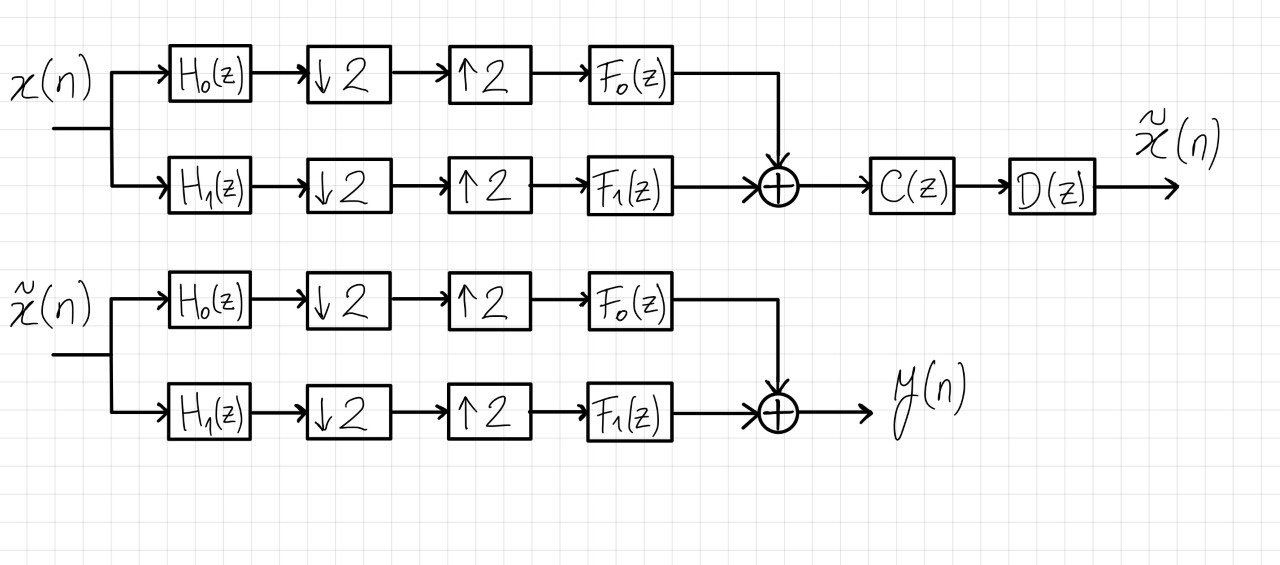

In order to achive this we are going to implement the figure seen above, with an input signal $x[n]=\delta[n]$ we obtain at the output $\hat{X}(z) = c^2 z^{-(2N-2)} C(z) D(z)$. As our objective is to estimate $C(z)$, we take the equality $\hat{X}(z) = C(z)$ which results in chosing $D(z)=\frac{1}{c^2}z^{2N-2}$.

We arrived to the desired result and we can estimate $C(z)$ with this method.